# Notations

$(0,T]$:  The observation interval during which neuron spiking activity were recorded

$N_{0,t}$: Sample path of spike times from the recorded neuron in $(0,t]$, for $t \in (0,T]$

$K$: divide $(0,T]$ into $K$ intervals with width $\Delta = \frac{T}{K}$ such that there is at most one spike per interval

$k\Delta$: The point at which the latent process model is evaluated, for $k = 1,...,K$

$\Delta N_k$: The number of spikes at time k.

$H_K = \{\Delta N_{1},...,\Delta N_{K}\}$: history of spiking activity in $(0,K]$


## Define the 1-dimensional state space model

$$\left\{
\begin{array}{ll}
      x_k = x_{k-1} + \epsilon_k, \epsilon_k \sim N(0,\sigma^2_{\epsilon K}) & (a) \\
      \lambda_r(k\Delta)\Delta = \frac{e^{x_k}}{1+e^{x_k}} & (b)\\
      \Delta N_{k} | x_k \sim Bernoulli(\lambda_r(k\Delta)\Delta) & (c)
\end{array} 
\right. $$

## Complete Data Likelihood
\begin{align*}
p(N_{0,K}, x; \theta) &= p(N_{0,K}|\boldsymbol{x})p(\boldsymbol{x})\\
&= \prod\limits_{k=1}^{K}\left\{p(\Delta N_{k}|x_k)\right\}\prod\limits_{k=1}^{K} p(x_k|x_{k-1}; \sigma_{\epsilon K}^2)
\end{align*}

where 
\begin{align*}
p(x; \theta) &= (2\pi \sigma_{\epsilon K}^2)^{\frac{-K}{2}} \exp {\left\{-\sum_{k=1}^{K} \frac{(x_k-x_{k-1})^2}{2\sigma_{\epsilon K}^2}\right\}}
\end{align*}

\begin{align*}
p(N_{0,K}|x) &= \prod\limits_{k=1}^{K} (\lambda_r(k\Delta)\Delta )^{\Delta N_{k}} (1-(\lambda_r(k\Delta)\Delta))^{1-\Delta N_{k}}
\end{align*}

### E-step:
\begin{align*}
Q(\theta|\theta^{l}) &= E\left\{\log [p(N_{0,K}, x; \theta)]|| H_K, \theta^{(l)} \right\}\\
&=\int \log p(N_{0,K}, x; \theta) p(x|H_k,\theta^{(l-1)}) dx
\end{align*}

#### use Sequential Monte Carlo to sample backward smoother 

%% $E\{x_k || H_k, \theta^{(l)}\}$, $E\{x_k^2 || H_k, \theta^{(l)}\}$ and $E\{x_k x_{k-1} || H_k, \theta^{(l)}\}$

In [1]:
%matplotlib inline
import numpy
import math
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import matplotlib.pyplot as plt
import scipy

Falling back to pure python implementaton, expect horrible performance


In [2]:
def generate_dataset(steps, P0, Q):
    x = numpy.zeros((steps + 1,))
    y = numpy.zeros((steps + 1,))
    x[0] = numpy.random.multivariate_normal((0.0,), P0)
    y[0] = numpy.random.binomial(1,numpy.exp(x[0])/(1.0+numpy.exp(x)[0]))
    for k in range(0, steps):
        x[k + 1] = x[k] + numpy.random.multivariate_normal((0.0,), Q)
        y[k + 1] = numpy.random.binomial(1,numpy.exp(x[k+1])/(1.0 + numpy.exp(x[k+1])))

    return (x, y)

#### We use the nlg.NonlinearGaussianInitialGaussian base class but modify the Gaussian noise of measurement. Log-pdf value of the measurement have to be changed. Furthermore, we need to override the calc_g and calc_f methods.

In [3]:
from scipy.stats import bernoulli
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Bernoulli(\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        return numpy.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        lpy = numpy.empty(N)
        g = self.calc_g(particles=particles, t=t)
 

        if (g is None):
            g = numpy.repeat(self.g.reshape((1, -1, 1)), N, 0)
        else:
            g = g.reshape((N, -1, 1))
        yrep = numpy.repeat(numpy.asarray(y).reshape((1, -1, 1)), N, 0)
        diff = yrep - g
        
        lpy = numpy.empty(N)
        for i in xrange(N):
            lpy[i] = bernoulli.logpmf(diff[i],numpy.exp(particles[i])/(1.0 + numpy.exp(particles[i])))

        return lpy

#### Define the length of the dataset and the noise parameters for our model.

In [4]:
T = 50
P0 = 1.0 * numpy.eye(1)
Q = 1.0 * numpy.eye(1)

# Forward particles
N = 1000
# Backward trajectories
M = 500

#### Instantiate our model using the parameters defined above.

In [5]:
model = StdNonLin(P0, Q)

In [6]:
numpy.random.seed(0)
(x, y) = generate_dataset(T, P0, Q)
print y

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


#### Create a simulator object using our previously instatiated model combined with the measurements y. This example doesn’t use any input signals u. Use N particle for the filter, M trajectories for the smoother. Generally N>M. For the filtering algorithm use the standard bootstrap particle filter, for the smoothing use backward simulation. Indicate that the first measurement is of the initial state.

In [7]:
sim = simulator.Simulator(model, u=None, y=y)
sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

12

#### Extract the filtered estimates, and computed the weighed mean of the filtered estimates.

In [8]:
(est_filt, w_filt) = sim.get_filtered_estimates()
mean_filt = sim.get_filtered_mean()

#### Extract smoothed estimates and mean and plot the mean.

In [9]:
est_smooth = sim.get_smoothed_estimates()

mean_smooth = sim.get_smoothed_mean()

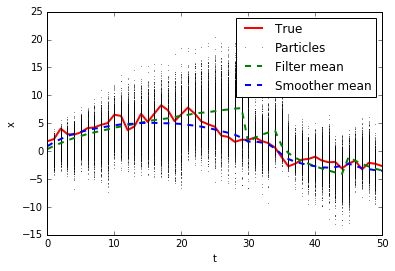

In [10]:
plt.plot(range(T + 1), x, 'r-', linewidth=2.0, label='True')
plt.plot((0,) * N, est_filt[0, :, 0].ravel(), 'k.',
        markersize=0.5, label='Particles')
for t in xrange(1, T + 1):
    plt.plot((t,) * N, est_filt[t, :, 0].ravel(),
             'k.', markersize=0.5)
plt.plot(range(T + 1), mean_filt[:, 0], 'g--',
         linewidth=2.0, label='Filter mean')
plt.plot(range(T + 1), mean_smooth[:, 0], 'b--',
         linewidth=2.0, label='Smoother mean')
plt.xlabel('t')
plt.ylabel('x')
plt.legend(loc='best')

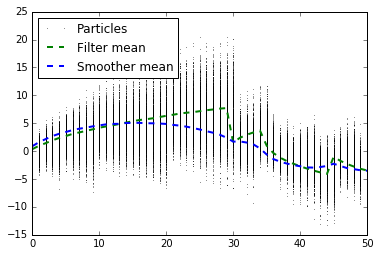

In [20]:
rmse_filt = 0.0
rmse_smooth = 0.0
rmse2_filt = 0.0
rmse2_smooth = 0.0

err = mean_filt.ravel() - x
rmse_filt += numpy.sqrt(numpy.mean(err ** 2))

tmp = 0.0
plt.plot((0,) * N, est_filt[0, :, 0].ravel(), 'k.', markersize=0.5, label='Particles')
for t in xrange(1, T + 1):
    plt.plot((t,) * N, est_filt[t, :, 0].ravel(), 'k.', markersize=0.5)
    tmp += numpy.sum(w_filt[t] * (est_filt[t, :, 0] - x[t]) ** 2)
rmse2_filt += numpy.sqrt(tmp / T)

if (M > 0):
    est_smooth = sim.get_smoothed_estimates()

    mean_smooth = sim.get_smoothed_mean()
    err = mean_smooth.ravel() - x
    rmse_smooth += numpy.sqrt(numpy.mean(err ** 2))

    tmp = 0.0
    for k in xrange(M):
        tmp += 1.0 / M * numpy.sum((est_smooth[:, k, 0].ravel() - x) ** 2)
    rmse2_smooth += numpy.sqrt(tmp / T)

plt.ioff()
plt.plot(range(T + 1), mean_filt[:, 0], 'g--', linewidth=2.0, label='Filter mean')
plt.plot(range(T + 1), mean_smooth[:, 0], 'b--', linewidth=2.0, label='Smoother mean')
plt.legend(loc='best')
plt.draw()
plt.show()

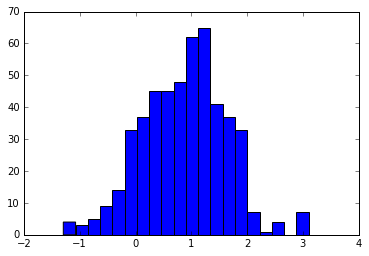

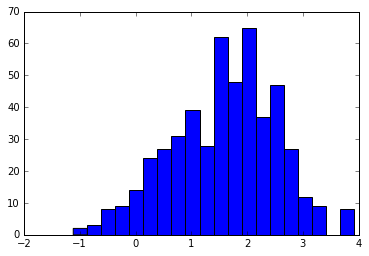

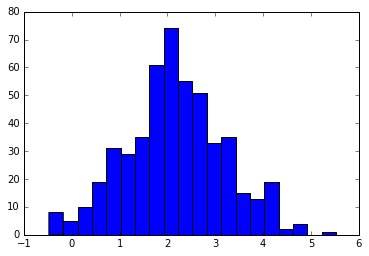

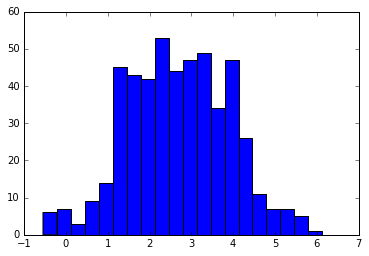

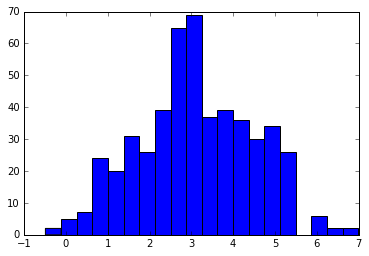

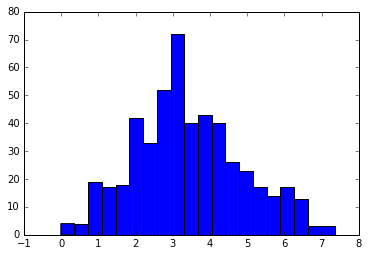

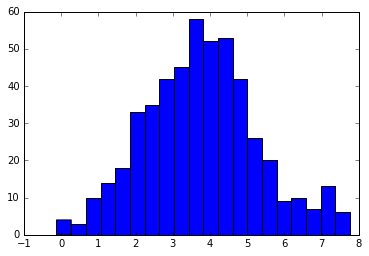

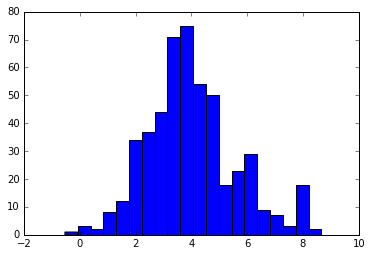

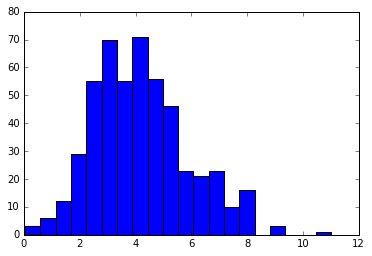

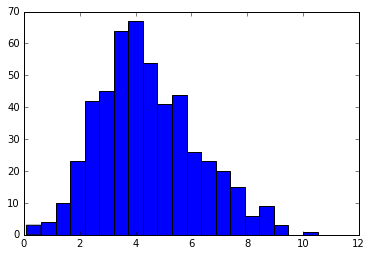

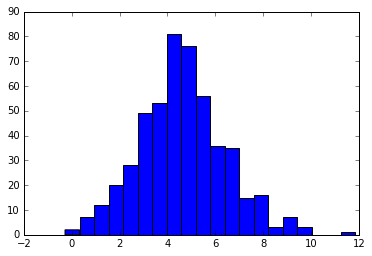

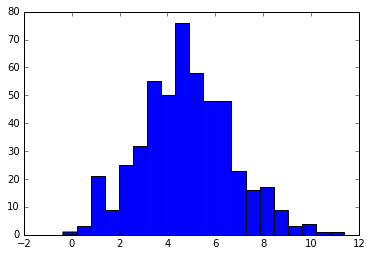

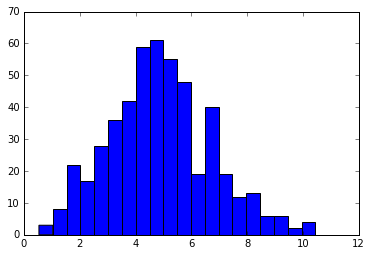

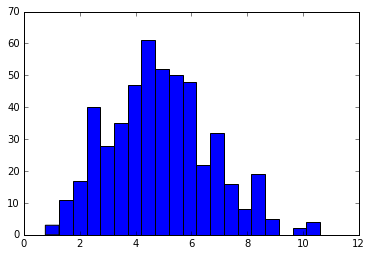

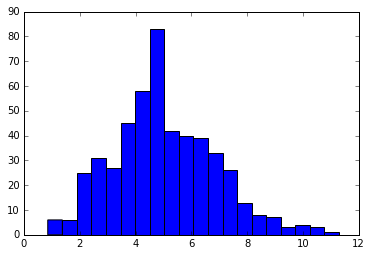

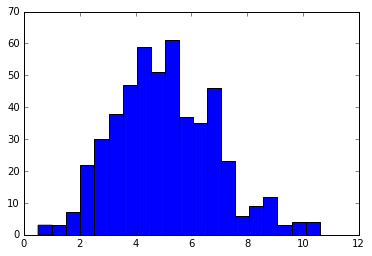

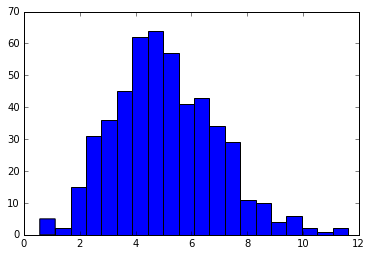

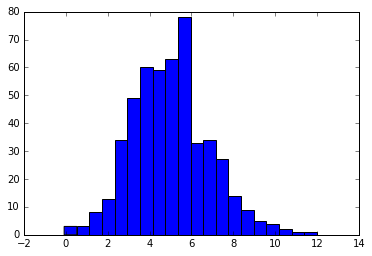

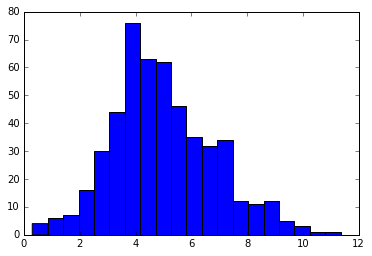

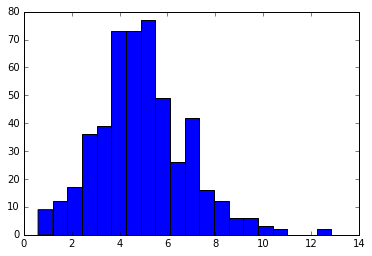

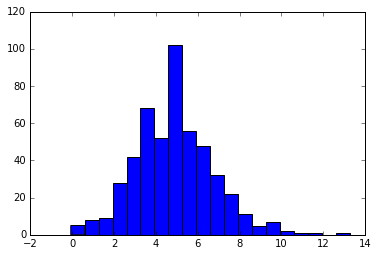

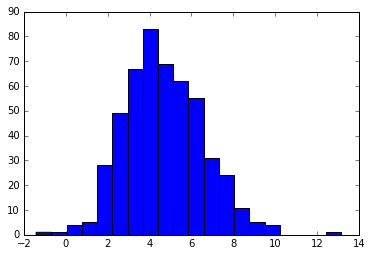

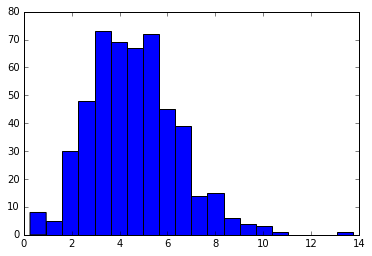

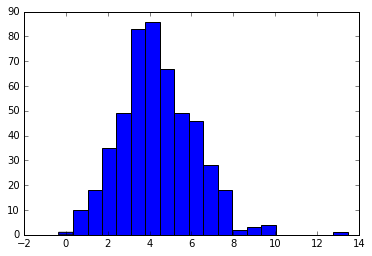

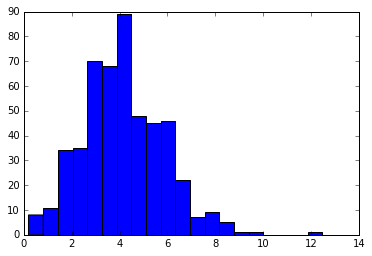

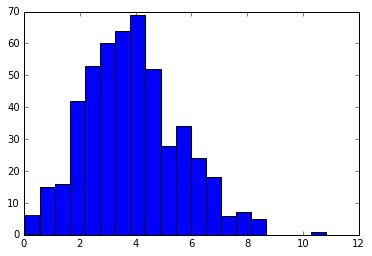

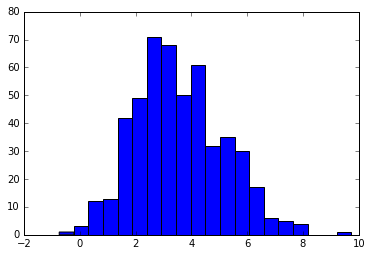

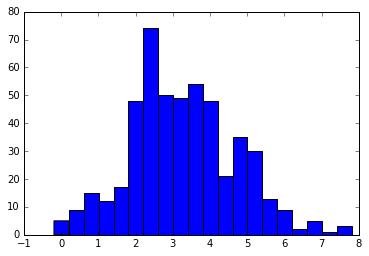

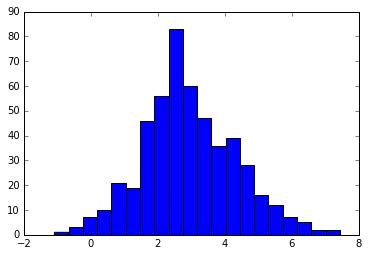

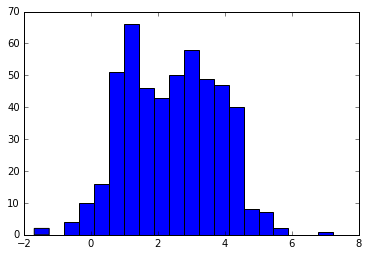

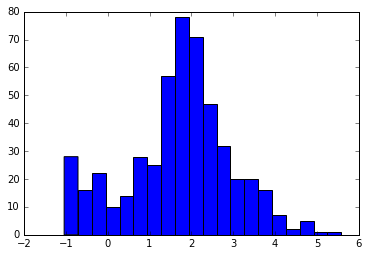

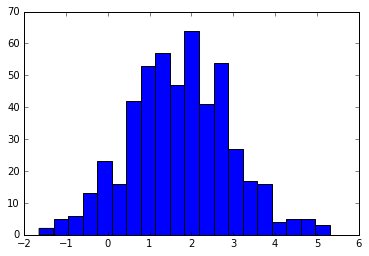

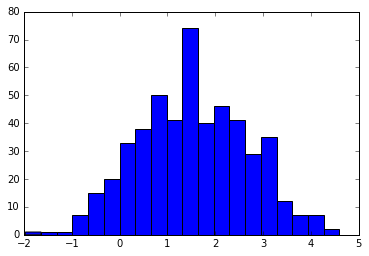

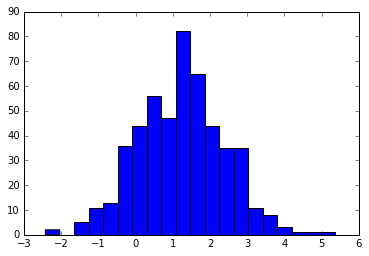

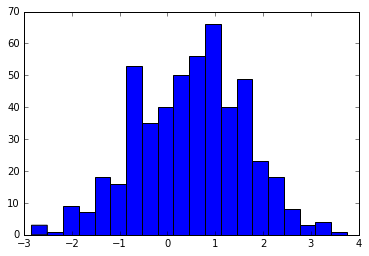

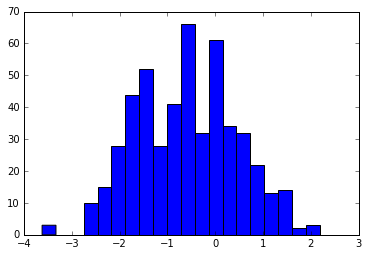

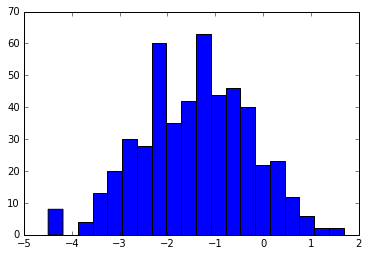

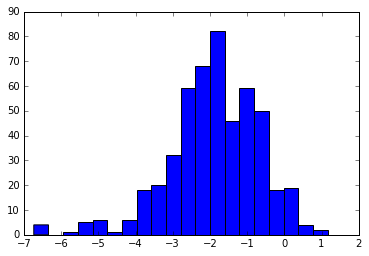

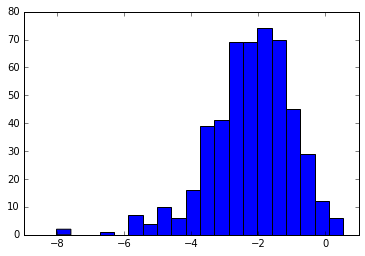

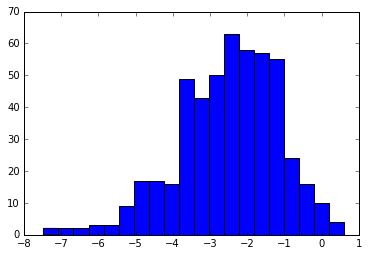

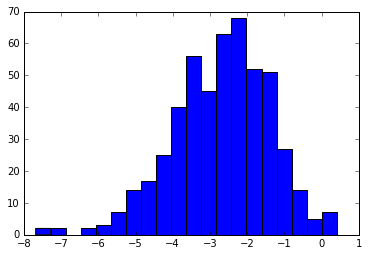

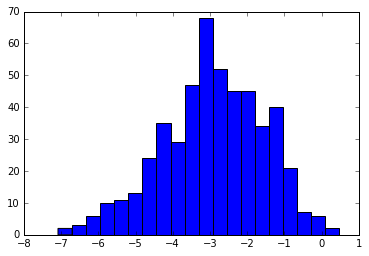

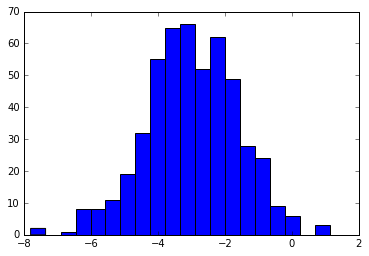

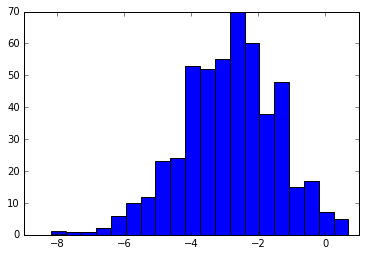

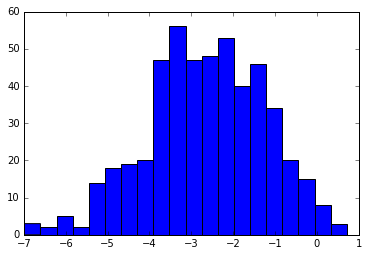

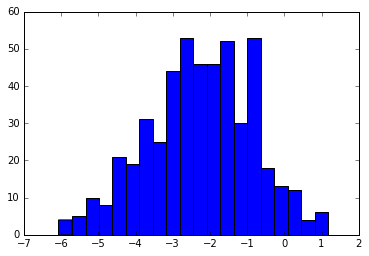

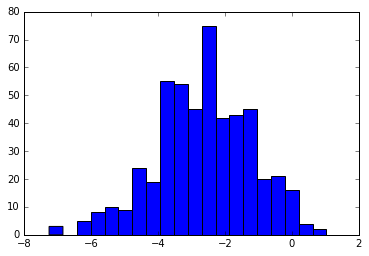

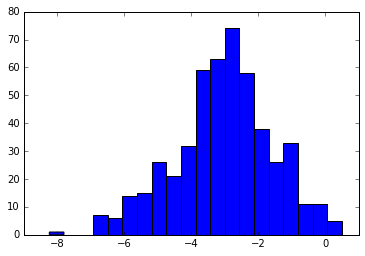

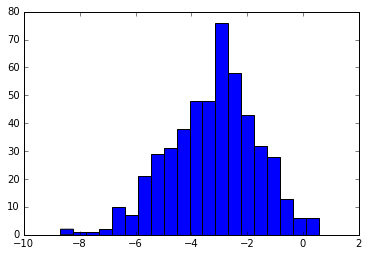

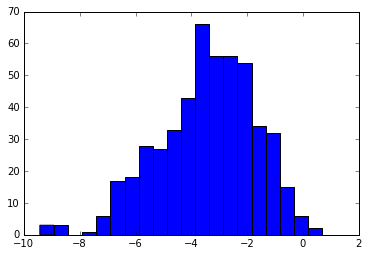

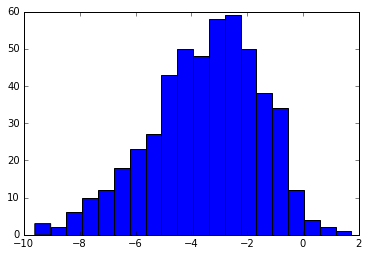

In [12]:
for i in xrange(51):
    plt.hist(est_smooth[i,:,0], bins = 20)
    plt.show()